In [2]:
import os
os.environ['TORCH_SHOW_CPP_STACKTRACES'] = '0'  # Suppress flash attention warning
os.environ['TORCH_WARN_ONLY_ONCE'] = '1'  # Show warnings only once

directory = r'D:\github\Cricket-Prediction\data\pytorchData'
import pickle
from torch.utils.data import Dataset
import torch
from tqdm import tqdm

# Create a custom Dataset
class CricketDataset(Dataset):
    def __init__(self, team_stats_list, player_stats_list, ball_stats_list):
        self.team_stats_list = team_stats_list
        self.player_stats_list = player_stats_list
        self.ball_stats_list = ball_stats_list

    def __len__(self):
        return len(self.team_stats_list)

    def __getitem__(self, idx):
        team_input = torch.tensor(self.team_stats_list[idx], dtype=torch.float32)
        team_input = team_input.squeeze()  # Remove extra dimensions
        player_input = torch.tensor(self.player_stats_list[idx], dtype=torch.float32)
        ball_stats = torch.tensor(self.ball_stats_list[idx], dtype=torch.float32)
        # Assuming the last column is the label
        ball_input = ball_stats[:, :-1]
        label = ball_stats[0, -1]
        return team_input, player_input, ball_input, label

# Define a collate function to handle variable-length sequences
def collate_fn(batch):
    team_inputs = []
    player_inputs = []
    ball_inputs = []
    labels = []
    ball_lengths = []

    for team_input, player_input, ball_input, label in batch:
        team_inputs.append(team_input)
        player_inputs.append(player_input)
        ball_inputs.append(ball_input)
        labels.append(label)
        ball_lengths.append(ball_input.shape[0])

    # Pad ball_inputs to the maximum sequence length in the batch
    max_seq_len = max(ball_lengths)
    padded_ball_inputs = torch.zeros(len(ball_inputs), max_seq_len, ball_inputs[0].shape[1])
    for i, ball_input in enumerate(ball_inputs):
        seq_len = ball_input.shape[0]
        padded_ball_inputs[i, :seq_len, :] = ball_input

    team_inputs = torch.stack(team_inputs)
    player_inputs = torch.stack(player_inputs)
    labels = torch.tensor(labels, dtype=torch.float32)
    return team_inputs, player_inputs, padded_ball_inputs, labels, ball_lengths


train_dataloader = pickle.load(open(os.path.join(directory, 'train_dataloader.pkl'), 'rb'))
val_dataloader = pickle.load(open(os.path.join(directory, 'val_dataloader.pkl'), 'rb'))
test_dataloader = pickle.load(open(os.path.join(directory, 'test_dataloader.pkl'), 'rb'))

In [4]:
import torch.nn as nn
# Define the models
class TeamStatsModel(nn.Module):
    def __init__(self, input_size):
        super(TeamStatsModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

class PlayerStatsModel(nn.Module):
    def __init__(self, input_size):
        super(PlayerStatsModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * ((input_size - 4) // 4), 16)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch, channels, seq_len)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        return x

class BallToBallModel(nn.Module):
    def __init__(self, input_dim):
        super(BallToBallModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 128, batch_first=True, bidirectional=False)  # Not bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 16)  # Adjust input size to 128

    def forward(self, x, lengths):
        # Pack the sequences
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        output_packed, (hn, cn) = self.lstm(x_packed)
        # Use the final hidden state directly
        hn = hn[-1,:,:]
        x = self.dropout(hn)
        x = F.relu(self.fc(x))
        return x

class CombinedModel(nn.Module):
    def __init__(self, team_input_size, player_input_size, ball_input_dim):
        super(CombinedModel, self).__init__()
        self.team_model = TeamStatsModel(team_input_size)
        self.player_model = PlayerStatsModel(player_input_size)
        self.ball_model = BallToBallModel(ball_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(16+16+16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, team_input, player_input, ball_input, ball_lengths):
        team_output = self.team_model(team_input)
        player_output = self.player_model(player_input)
        ball_output = self.ball_model(ball_input, ball_lengths)
        combined = torch.cat((team_output, player_output, ball_output), dim=1)
        output = self.fc(combined)
        return output.squeeze()

In [21]:
import os
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F  # Import F module
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data using polars
directory = r'D:\github\Cricket-prediction\data\filteredData'
balltoball = pl.read_csv(os.path.join(directory, 'balltoball.csv'))
teamStats = pl.read_csv(os.path.join(directory, 'team12Stats.csv'))
playersStats = pl.read_csv(os.path.join(directory, 'playersStats.csv'))

# Preprocess the data
def partition_data(df, group_keys):
    partitions = df.partition_by(group_keys)
    partition_list = [partition.drop(group_keys).to_numpy() for partition in partitions]
    return partition_list

team_stats_partitions = partition_data(teamStats, ['match_id', 'flip'])
player_stats_partitions = partition_data(playersStats, ['match_id', 'flip'])
ball_stats_partitions = partition_data(balltoball, ['match_id', 'flip'])

team_stats_partitions[0].shape

(1, 23)

In [31]:
train_dataloader.dataset[0][2].shape[1],  ball_stats_partitions[0].shape[1]

(4, 5)

In [33]:
team_input_size, player_input_size, ball_input_dim

(23, 22, 3)

In [35]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
team_input_size = train_dataloader.dataset[0][0].shape[0]
player_input_size =train_dataloader.dataset[0][1].shape[0]
ball_input_dim = train_dataloader.dataset[0][2].shape[1]  # Exclude label

model = CombinedModel(team_input_size, player_input_size, ball_input_dim).to(device)  # Move model to GPU

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Weight decay for regularization
criterion = nn.BCELoss()

# Implement early stopping
best_loss = np.inf
patience = 10
trigger_times = 0

# Training loop with tqdm
num_epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for team_input, player_input, ball_input, labels, ball_lengths in progress_bar:
        team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(team_input, player_input, ball_input, ball_lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix(loss=loss.item())
    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for team_input, player_input, ball_input, labels, ball_lengths in val_dataloader:
            team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
            outputs = model(team_input, player_input, ball_input, ball_lengths)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            val_correct_predictions += (predictions == labels).sum().item()
            val_total_predictions += labels.size(0)
    avg_val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

Epoch 1/5: 100%|██████████| 3771/3771 [01:46<00:00, 35.29it/s, loss=0.647]


Epoch [1/5], Train Loss: 0.6280, Train Accuracy: 0.6400
Epoch [1/5], Val Loss: 0.4620, Val Accuracy: 0.8023


Epoch 2/5: 100%|██████████| 3771/3771 [01:47<00:00, 35.01it/s, loss=0.398] 


Epoch [2/5], Train Loss: 0.3732, Train Accuracy: 0.8454
Epoch [2/5], Val Loss: 0.1729, Val Accuracy: 0.9450


Epoch 3/5: 100%|██████████| 3771/3771 [01:47<00:00, 35.15it/s, loss=0.468]  


Epoch [3/5], Train Loss: 0.1579, Train Accuracy: 0.9449
Epoch [3/5], Val Loss: 0.0445, Val Accuracy: 0.9886


Epoch 4/5: 100%|██████████| 3771/3771 [01:46<00:00, 35.33it/s, loss=0.205]   


Epoch [4/5], Train Loss: 0.0710, Train Accuracy: 0.9770
Epoch [4/5], Val Loss: 0.0084, Val Accuracy: 0.9993


Epoch 5/5: 100%|██████████| 3771/3771 [01:47<00:00, 35.14it/s, loss=0.0746]  


Epoch [5/5], Train Loss: 0.0394, Train Accuracy: 0.9873
Epoch [5/5], Val Loss: 0.0033, Val Accuracy: 0.9997


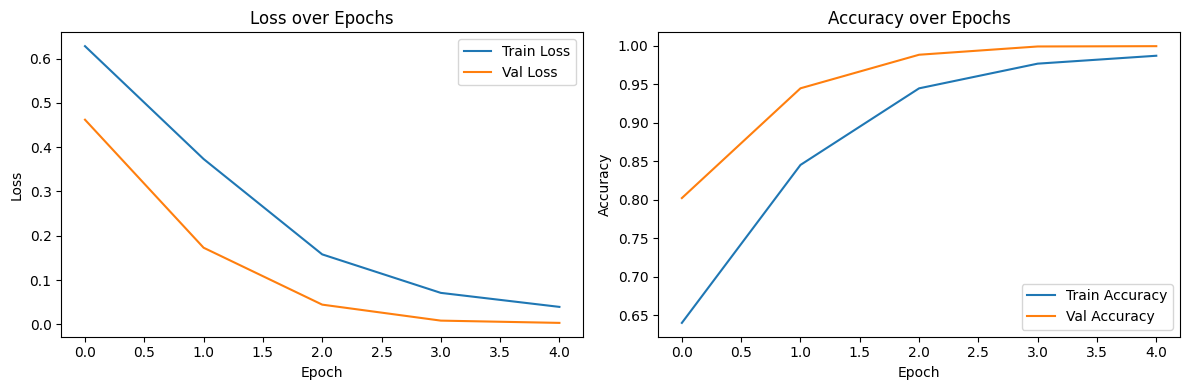

In [36]:
import matplotlib.pyplot as plt
# Save the model
torch.save(model.state_dict(), 't20i.pth')

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.savefig('training_validation_history.png')
plt.show()